# Business understanding

Generator planet 
- format wejściowy plików:  1920px/1080px
- format wyjściowy plików:  512px/512px

In [1]:
# import niezbednych bibliotek
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from datetime import date

import uuid

In [2]:
# wersja tensorflow
print('tensorflow ver: ', tf.__version__)
print('keras ver     : ', tf.keras.__version__)

tensorflow ver:  2.10.1
keras ver     :  2.10.0


# Data understanding and data preparation

Dataset zrobiony z modeli udostępnionych przez NASA na stronie: nasa.gov
- 12 planet/gwiazd
- 100 zdjęć na planetę/gwiazde

wybór - 4 planet/gwiazd

In [3]:
dir_directory_path = './DATA/v1'

images_data = []
images_labels = []
    
subfolders = [ f.path for f in os.scandir(dir_directory_path) if f.is_dir() ]

for dir_path in subfolders:
    print('Loading data from folder', dir_path.replace("\\", "/"))

    if dir_path.find('sun') == -1 and dir_path.find('mars') == -1 and dir_path.find('earth') == -1: 
        continue
    
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                dir_path, 
                label_mode=None, 
                image_size=(512, 912), 
                batch_size=32,
                #color_mode='grayscale'
            )
    
    for i in dataset:
        for ii in i:
            new_img = ii[0:512, 200: 712]
            images_data.append(new_img)
            images_labels.append(dir_path.replace(dir_directory_path, '').replace('\\',''))
                        
images_data = np.asarray(images_data)
images_labels = np.asarray(images_labels)

new_images_data = []
new_images_labels = []

for idx in range(0, images_data.shape[0]):
    img = Image.fromarray(np.uint8(images_data[idx]))
    class_name = images_labels[idx]
    
    new_images_data.append(np.asarray(img))
    new_images_labels.append(class_name)
    
    #for i in range(180,360,180):
        #rotated_img = img.rotate(i)
        #new_images_data.append(np.asarray(rotated_img))
        #new_images_labels.append(class_name)
                        
images_data = np.asarray(new_images_data)
images_labels = np.asarray(new_images_labels)        

label_encoder = LabelEncoder()
images_labels_num = label_encoder.fit_transform(images_labels)

print()
print('Shapes:')
print('images_labels      :', images_labels.shape)
print('-----------------------------')
print('images_data        :', images_data.shape)
print('images_labels_num  :', images_labels_num.shape)

Loading data from folder ./DATA/v1/ceres
Loading data from folder ./DATA/v1/earth
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/earth_moon
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/eris
Loading data from folder ./DATA/v1/hamuea
Loading data from folder ./DATA/v1/jupiter
Loading data from folder ./DATA/v1/makemake
Loading data from folder ./DATA/v1/mars
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/mercury
Loading data from folder ./DATA/v1/pluto
Loading data from folder ./DATA/v1/sun
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/venus

Shapes:
images_labels      : (400,)
-----------------------------
images_data        : (400, 512, 512, 3)
images_labels_num  : (400,)


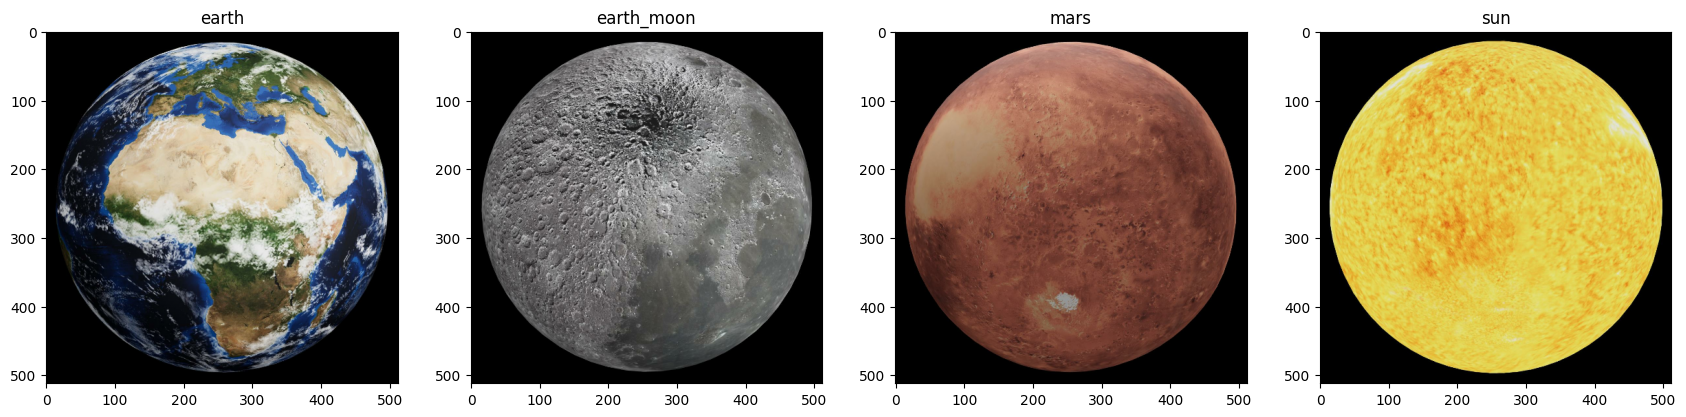

In [4]:
np.random.seed(100)

idx = 0
fig = plt.figure(figsize=(21, 21))
for i in np.unique(images_labels_num):    
    idx += 1
    class_position = np.where(images_labels_num  == i)[0]
    class_position = np.random.choice(class_position)
    plt.subplot(4, 4, idx)
    plt.imshow(images_data[class_position] / 255.)
    plt.title(images_labels[class_position])    
    #plt.axis('off')
plt.show()
plt.close(fig)

In [5]:
train_images = images_data
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
train_images.shape

(400, 512, 512, 3)

# Modeling

In [7]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1  

In [8]:
def create_generator():
    model = Sequential()
    
    model.add(layers.Dense(512 * 512 * 8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((512, 512, 8)))
    
    model.add(layers.Dense(32, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(3, use_bias=False, activation='tanh'))
    model.add(layers.BatchNormalization())
    
    return model

generator=create_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2097152)           209715200 
                                                                 
 batch_normalization (BatchN  (None, 2097152)          8388608   
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2097152)           0         
                                                                 
 reshape (Reshape)           (None, 512, 512, 8)       0         
                                                                 
 dense_1 (Dense)             (None, 512, 512, 32)      256       
                                                                 
 batch_normalization_1 (Batc  (None, 512, 512, 32)     128       
 hNormalization)                                        

In [9]:
def create_discriminator():
    model = Sequential()
    
    model.add(layers.Dense(32, use_bias=False, input_shape=[512, 512, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(32, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
     
    return model

discriminator=create_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512, 512, 32)      96        
                                                                 
 batch_normalization_3 (Batc  (None, 512, 512, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512, 512, 32)      0         
                                                                 
 dense_4 (Dense)             (None, 512, 512, 32)      1024      
                                                                 
 batch_normalization_4 (Batc  (None, 512, 512, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512, 512, 32)     

In [10]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}  

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(11, 11))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('./results_512_v1/S{:03d}_E{:03d}.jpg'.format(SESJA, epoch + 1)) 
        if epoch == 0 or epoch % 5 == 0:
            plt.show()
        plt.close(fig)
                
        for i in range(self.num_img):
            fig = plt.figure(figsize=(5.6, 5.6))
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
            plt.savefig('./results_512_v1/images/S{:03d}_E{:03d}_IMG{:03d}.jpg'.format(SESJA, epoch + 1, i + 1)) 
            plt.close(fig)
            
        if epoch % 10 == 0:
            self.model.generator.save('./results_512_v1/generator_512_S{:03d}_E{:03d}_.h5'.format(SESJA, epoch + 1))

    def on_train_end(self, logs=None):
        self.model.generator.save('./results_512_v1/generator_512_S{:03d}.h5'.format(SESJA))

In [12]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

D_LR = 0.001 # UPDATED: discriminator learning rate
G_LR = 0.003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Evaluation

Epoch 1/2
13/13 [==============================] - ETA: 0s - d_loss: -6.1188 - g_loss: 1165.4875 

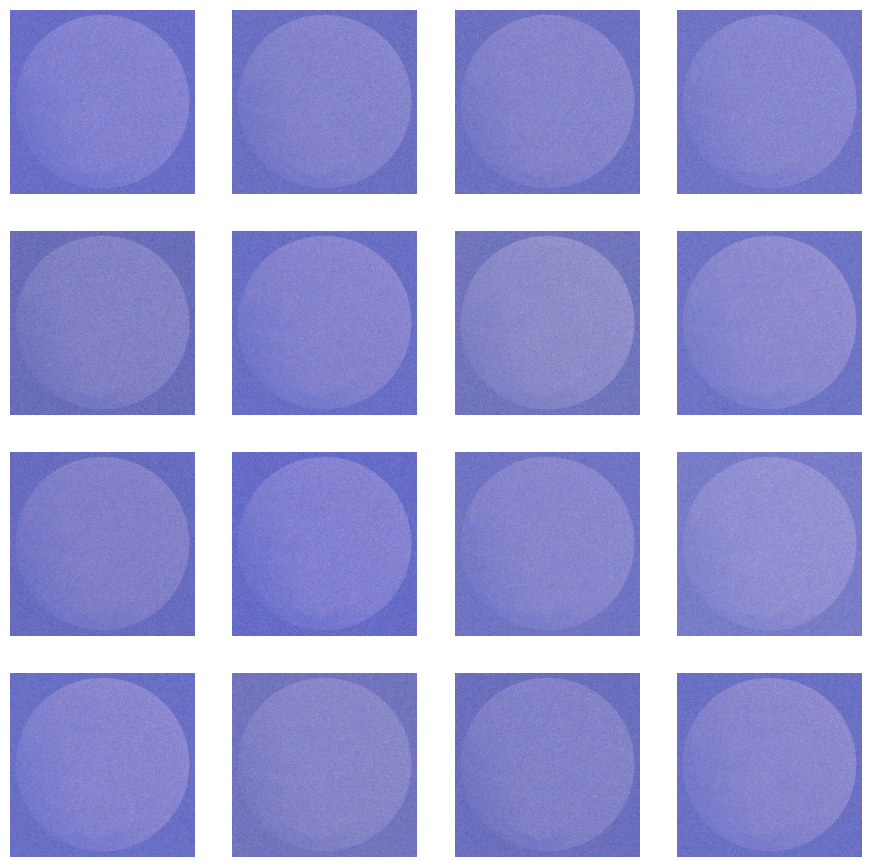

13/13 [==============================] - 213s 16s/step - d_loss: -6.1188 - g_loss: 1165.4875
Epoch 2/2
13/13 [==============================] - 197s 15s/step - d_loss: -38.0688 - g_loss: 47.8243


In [13]:
# number of epochs
NUM_EPOCHS = 2 
SESJA = 1

dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])